In [ ]:
!pip install statsmodels

# 데이터를 통해 forward, backward, stepwise 모두 진행

In [2]:
import pandas as pd
missing_to_median_scaled=pd.read_csv("missing_to_median_scaled")
missing_to_median_scaled = missing_to_median_scaled.dropna()
data = missing_to_median_scaled.drop("TARGET", axis = 1)
target = missing_to_median_scaled["TARGET"]
target.unique()

FileNotFoundError: [Errno 2] No such file or directory: 'missing_to_median_scaled'

In [ ]:
# 데이터 샘플링 (예: 20% 샘플 사용)
data_sampled = data.sample(frac=0.3, random_state=42)  # 10% 샘플링
target_sampled = target.loc[data_sampled.index]

## 각 모델들 정의

In [ ]:
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt

def forward_selection_with_visualization(data, target, significance_level=0.05):
    initial_features = []
    remaining_features = list(data.columns)
    selected_features = []
    performance = []  # 단계별 모델 성능 기록 (AIC 사용)

    while remaining_features:
        best_feature = None
        best_pvalue = float('inf')

        for feature in remaining_features:
            test_features = selected_features + [feature]
            X = sm.add_constant(data[test_features])
            model = sm.OLS(target, X).fit()
            pvalue = model.pvalues[feature]
            aic = model.aic

            if pvalue < significance_level and pvalue < best_pvalue:
                best_feature = feature
                best_pvalue = pvalue

        if best_feature:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)

            # 모델 성능 저장
            X = sm.add_constant(data[selected_features])
            model = sm.OLS(target, X).fit()
            performance.append((len(selected_features), model.aic))  # 단계, AIC 저장
        else:
            break

    return selected_features, performance


In [ ]:
def forward_selection(data, target, significance_level=0.05):
    initial_features = []
    remaining_features = list(data.columns)
    selected_features = []

    while remaining_features:
        best_feature = None
        best_pvalue = float('inf')

        for feature in remaining_features:
            test_features = selected_features + [feature]
            X = sm.add_constant(data[test_features])
            model = sm.OLS(target, X).fit()
            pvalue = model.pvalues[feature]

            if pvalue < significance_level and pvalue < best_pvalue:
                best_feature = feature
                best_pvalue = pvalue

        if best_feature:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
        else:
            break

    return selected_features


In [ ]:
def stepwise_selection(data, target, significance_level_in=0.05, significance_level_out=0.05):
    selected_features = []
    remaining_features = list(data.columns)
    last_removed = None

    while True:
        added = False
        removed = False

        # Forward Step
        best_feature = None
        best_pvalue = float('inf')

        for feature in remaining_features:
            test_features = selected_features + [feature]
            X = sm.add_constant(data[test_features])
            model = sm.OLS(target, X).fit()
            pvalue = model.pvalues[feature]

            if pvalue < significance_level_in and pvalue < best_pvalue:
                best_feature = feature
                best_pvalue = pvalue

        if best_feature:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            added = True

        # Backward Step
        if len(selected_features) > 0:
            X = sm.add_constant(data[selected_features])
            model = sm.OLS(target, X).fit()
            pvalues = model.pvalues.iloc[1:]  # 상수(const)는 제외

            max_pvalue = pvalues.max()
            if max_pvalue > significance_level_out:
                excluded_feature = pvalues.idxmax()
                selected_features.remove(excluded_feature)
                remaining_features.append(excluded_feature)
                last_removed = excluded_feature
                removed = True

        if not added and not removed:
            break

    return selected_features


## 실행결과

In [ ]:

# Forward Selection 실행
selected_features = forward_selection_with_visualization(data_sampled, target_sampled)
print("Selected features:", selected_features)

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression

# 모델 정의
model = LogisticRegression()

# SequentialFeatureSelector 사용
sfs = SequentialFeatureSelector(
    model,
    k_features="best",
    forward=True,  # Forward Selection
    scoring="r2",  # R² 기준 평가
    cv=5,  # Cross-validation
    n_jobs=-1  # 병렬 처리 사용
)

# 피팅
sfs = sfs.fit(data_sampled, target_sampled)

# 선택된 feature
print("Selected features:", sfs.k_feature_names_)
print("Final R² score:", sfs.k_score_)




Selected features: None
Final R² score: None



STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

## 변수 선택 전 기본 모델 성능 확인

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=42)


In [ ]:
from sklearn.linear_model import LogisticRegression

# statsmodels 학습모델 구축
lr = sm.Logit(y_train, X_train)

# 모델 적합
result = lr.fit()
result.summary()

In [ ]:
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

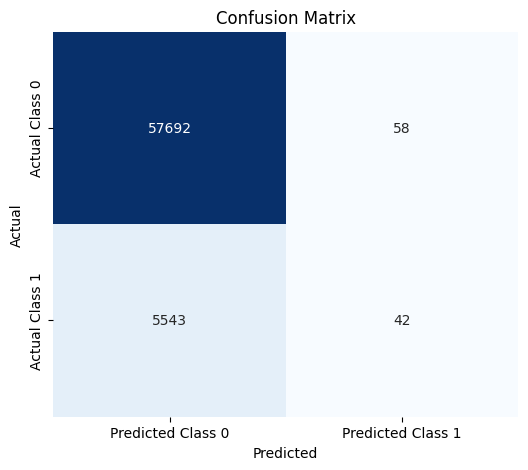


Evaluation Metrics:
Recall: 0.912
Precision: 0.869
F1 Score: 0.871


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score

# 2. 예측
y_pred = model.predict(X_test)  # X_test로 예측값 생성
# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test, y_pred)

# 혼동 행렬 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=['Predicted Class 0', 'Predicted Class 1'], 
            yticklabels=['Actual Class 0', 'Actual Class 1'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
# Recall, Precision, F1 Score
recall = recall_score(y_test, y_pred, average='weighted')   # 'weighted'는 클래스 불균형 고려
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("\nEvaluation Metrics:")
print(f"Recall: {recall:.3f}")
print(f"Precision: {precision:.3f}")
print(f"F1 Score: {f1:.3f}")